In [1]:
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns


plt.style.use('seaborn-darkgrid')
np.random.seed(0)

%matplotlib inline

In [2]:
train = pd.read_csv('../input/ion-switching-2-preprocessing/train.csv')
test = pd.read_csv('../input/ion-switching-2-preprocessing/test.csv')

# Augment data

In [3]:
sub_data_1 = train.iloc[2_500_000: 3_000_000]
sub_data_2 = train.iloc[-1_000_000: -500_000]

sub_signal_1 = sub_data_1['signal'].values
sub_signal_2 = sub_data_2['signal'].values
high_open_signal = train.iloc[-500_000:]['signal'].values
sub_signal = (sub_signal_1 + sub_signal_2)

In [4]:
sub_signal.mean(), high_open_signal.mean()

(7.147172071513265, 7.118307793297686)

In [5]:
sub_signal.std(), high_open_signal.std()

(1.458048294464432, 1.4587993458991557)

Because the mean and variance of the high open channels batch and this synthetic batch is same, we can use this data as new training examples. Additionally we can subtract values of this data from test data to make the predictions more easy.

In [6]:
sub_open_channels = sub_data_1['open_channels'].values + sub_data_2['open_channels'].values
sub_data = pd.DataFrame({
    'signal': sub_signal,
    'open_channels': sub_open_channels
})

train = pd.concat([train, sub_data])
train.reset_index(drop=True, inplace=True)

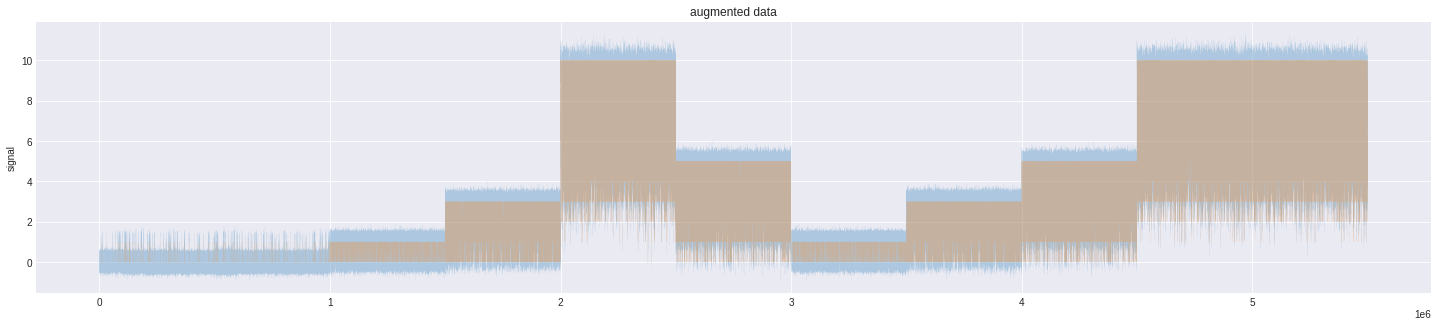

In [7]:
x = np.arange(len(train))

plt.figure(figsize=(25, 5))
plt.title('augmented data')
plt.ylabel('signal')
plt.plot(x, train['signal'], linewidth=0.1, alpha=0.3)
plt.plot(x, train['open_channels'], linewidth=0.1, alpha=0.3)
plt.show()

# Feature Engineering

* Since the range scale of both open channels and signal is the same, rounding the signal will be a good feature.
* Standard scaling each batch of the signal gives a relativistic way to check for open channels this seems a good feature.
* The power of a signal is proportional to the square of the signal. This can also be used as a feature. 
* Since the process is a hidden markov model, it depends only on the states directly preceding and directly succeeding it. If the data was a time series data considering the future would not be possible. But, since the data is a HMM, the future state is as influential as the past state. Since this is such an important feature we shift the data by steps of 1, 2, 3, 4 and 5. 
* Calculating the percentage change between the signal and the shifted signal is also considered.
* Finally, we bin and encode the signal so that it can be releated to the signal.

In [8]:
from sklearn.base import BaseEstimator, TransformerMixin

class ScaleSignal(BaseEstimator, TransformerMixin):
    '''
    For each batch scale that batch signal, i.e., 
    signal_scaled = (signal - batch_mean) / batch_std
    This feature will introduce a relative measure
    '''
    
    def __init__(self, batch_size, fill_value=0):
        
        super(ScaleSignal, self).__init__()
        
        self.batch_size = batch_size
        self.fill_value = fill_value
    
    def fit(self, X):
            
        return self
    
    
    def transform(self, X):
        
        data = X.copy()
        
        data['scaled_signal'] = np.empty(len(data))
        
        for i in range(len(data) // self.batch_size + 1):
            
            batch = data.iloc[i * self.batch_size: (i + 1) * self.batch_size]['signal']
            batch_mean, batch_std = batch.mean(), batch.std()
            
            scale = lambda x: (x - batch_mean) / batch_std
            
            data.loc[i * self.batch_size: (i + 1) * self.batch_size, 'scaled_signal'] =  batch.map(scale)
        
        data = data.fillna(self.fill_value)
            
        return data

In [9]:
class SquareSignal(BaseEstimator, TransformerMixin):
    
    '''
    Add a (signal) ^ 2 feature
    Since the power of a signal is proportional to square of the signal this feature will be useful
    '''
    
    def __init__(self, subtract_mean=False, batch_size=None, fill_value=0):
        super(SquareSignal, self).__init__()
        
        
        if subtract_mean and batch_size is None:
            raise ValueError('Batch size needed to subtract mean')
        else:
            self.subtract_mean = subtract_mean
            self.batch_size = batch_size
            
        self.batch_size = batch_size
        self.fill_value = fill_value
    
    def fit(self, X):
        return self
    
    def transform(self, X):
        data = X.copy()
        
        data['signal_squared'] = data['signal'].map(np.square)
        
        if self.subtract_mean:
            data['signal_squared_minus_mean'] = np.empty(len(data))
            
            for i in range(len(data) // self.batch_size + 1):
                batch = data.iloc[i * self.batch_size: (i + 1) * self.batch_size]
                batch_signal_mean = batch['signal'].mean()
                data.loc[i * self.batch_size: (i + 1) * self.batch_size, 'signal_squared_minus_mean'] = batch['signal_squared'] - batch_signal_mean
                
        data = data.fillna(self.fill_value)
        
        return data

In [10]:
class ShiftSignal(BaseEstimator, TransformerMixin):
    '''
    shift the values of the signal by certain timesteps
    since the process to model is a hidden markov model only the events directly preceding or succeeding it
    will have influence over the event
    '''
    
    def __init__(self, periods, fill_value=0, by_batch=False, batch_size=None):
        super(ShiftSignal, self).__init__()
        
        self.periods = periods
        self.fill_value = fill_value
        
        if by_batch and batch_size is None:
            raise ValueError('Batch size needed to subtract mean')
        else:
            self.by_batch = by_batch
            self.batch_size = batch_size
        
    def fit(self, X):
        return self
    
    def transform(self, X):
        data = X.copy()
        
        for period in self.periods:
            
            if self.by_batch:
                data['batch'] = np.arange(len(data)) // self.batch_size
                
                data[f'signal_shifted_by_{period}'] = data.groupby('batch')['signal'].shift(period, fill_value=self.fill_value)
                data[f'signal_shifted_by_{-period}'] = data.groupby('batch')['signal'].shift(-period, fill_value=self.fill_value)
                
                data.drop('batch', axis=1, inplace=True)
                
            else:
                data[f'signal_shifted_by_{period}'] = data['signal'].shift(period, fill_value=self.fill_value)

                data[f'signal_shifted_by_{-period}'] = data['signal'].shift(-period, fill_value=self.fill_value)
                
        return data
            

In [11]:
class PercentageChange(BaseEstimator, TransformerMixin):
    '''
    shift the values of the signal by certain timesteps
    since the process to model is a hidden markov model only the events directly preceding or succeeding it
    will have influence over the event
    '''
    
    def __init__(self, periods, by_batch=False, batch_size=None, fill_value=0):
        super(PercentageChange, self).__init__()
        
        self.periods = periods
        self.fill_value = fill_value
        
        if by_batch and batch_size is None:
            raise ValueError('Batch size needed to subtract mean')
        else:
            self.by_batch = by_batch
            self.batch_size = batch_size
        
    def fit(self, X):
        return self
    
    def transform(self, X):
        data = X.copy()
        
        for period in self.periods:
            
            if self.by_batch:
                data['batch'] = np.arange(len(data)) // self.batch_size
                
                data[f'percentage_change_{period}'] = data.groupby('batch')['signal'].pct_change(period)
                data[f'percentage_change_{-period}'] = data.groupby('batch')['signal'].pct_change(-period)
                
                data.drop('batch', axis=1, inplace=True)
                
            else:
                data[f'percentage_change_{period}'] = data['signal'].pct_change(period)

                data[f'percentage_change_{-period}'] = data['signal'].pct_change(-period)
                
            data.fillna(self.fill_value, inplace=True)
                
        return data
            

In [12]:
class RollingFeatures(BaseEstimator, TransformerMixin):
    '''
    add rolling window features to the data
    '''
    def __init__(self, windows, by_batch=False, batch_size=None, fill_value=0):
        super(RollingFeatures, self).__init__()
        
        self.windows = windows
        self.fill_value = fill_value
        
        if by_batch and batch_size is None:
            raise ValueError('Batch size needed to subtract mean')
        else:
            self.by_batch = by_batch
            self.batch_size = batch_size
        
    def fit(self, X):
        return self
    
    def transform(self, X):
        data = X.copy()
        
        for window in self.windows:
            
            if self.by_batch:
                
                mean_function = lambda x: x.rolling(window, center=True).mean()
                std_function = lambda x: x.rolling(window, center=True).std()
            
                data['batch'] = np.arange(len(data)) // self.batch_size
                
                data[f'rolling_mean_{window}'] = data.groupby('batch')['signal'].apply(mean_function)
                data[f'rolling_std_{window}'] = data.groupby('batch')['signal'].apply(std_function)
                
                data.drop('batch', axis=1, inplace=True)
            else:
                data[f'rolling_mean_{window}'] = data['signal'].rolling(window, center=True).mean()
                data[f'rolling_std_{window}'] = data['signal'].rolling(window, center=True).std()
            
        data.fillna(self.fill_value, inplace=True)
        
        return data

In [13]:
from sklearn.preprocessing import KBinsDiscretizer
from category_encoders import TargetEncoder

class SignalEncoder(BaseEstimator, TransformerMixin):
    '''
    Associate signal with corresponding target
    '''
    
    def __init__(self, n_bins=500, smoothing=1):
        super(SignalEncoder, self).__init__()
        
        self.n_bins = n_bins
        self.smoothing = smoothing
        
    def fit(self, X):
                
        self.kbd = KBinsDiscretizer(n_bins=self.n_bins, encode='ordinal', strategy='uniform')
        self.te = TargetEncoder(smoothing=self.smoothing)
        
        signal = X['signal'].values.reshape(-1, 1)
        
        discrete_signal = self.kbd.fit_transform(signal)
        self.te.fit(discrete_signal, X['open_channels'])
        
        return self
    
    def transform(self, X):
        data = X.copy()
        
        binned_signal = self.kbd.transform(data['signal'].values.reshape(-1, 1))
        data['target_encoded_signal'] = self.te.transform(binned_signal)
        
        return data
        

In [14]:
from sklearn.pipeline import Pipeline

mini_batch_size = 100_000
fill_value = -3 # fill with out of range value

scale = ScaleSignal(mini_batch_size, fill_value=fill_value)
square = SquareSignal(subtract_mean=True, batch_size=mini_batch_size, fill_value=fill_value)
shift = ShiftSignal([1, 2, 3, 4, 5], by_batch=True, batch_size=mini_batch_size, fill_value=fill_value)
pct_change = PercentageChange([1, 2, 3, 4, 5], by_batch=True, batch_size=mini_batch_size, fill_value=fill_value)
signal_encoder = SignalEncoder()
rolling = RollingFeatures([10, 100, 1000], by_batch=True, batch_size=mini_batch_size, fill_value=fill_value)

steps = [
    ('scale', scale),
    ('square', square),
    ('shift', shift),
    ('pct_change', pct_change),
    ('signal_encoder', signal_encoder),
    ('rolling', rolling),
]

pipeline = Pipeline(steps)

train = pipeline.fit_transform(train)
test = pipeline.transform(test)

In [15]:
import joblib

with open('feature_pipeline.pkl', 'wb') as pickle_file:
    joblib.dump(pipeline, pickle_file)

In [16]:
train.head()

,time,signal,open_channels,scaled_signal,signal_squared,signal_squared_minus_mean,signal_shifted_by_1,signal_shifted_by_-1,signal_shifted_by_2,signal_shifted_by_-2,...,percentage_change_-4,percentage_change_5,percentage_change_-5,target_encoded_signal,rolling_mean_10,rolling_std_10,rolling_mean_100,rolling_std_100,rolling_mean_1000,rolling_std_1000
0,0.0001,-0.017196,0,-0.255041,0.000296,-0.044093,-3.000000,-0.088056,-3.000000,0.255037,...,-0.947704,-3.0,-1.239089,37.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0
1,0.0002,-0.088056,0,-0.548495,0.007754,-0.036635,-0.017196,0.255037,-3.000000,-0.316691,...,-2.224315,-3.0,-3.622633,34.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0
2,0.0003,0.255037,0,0.872359,0.065044,0.020655,-0.088056,-0.316691,-0.017196,-0.328821,...,6.595922,-3.0,1.213968,48.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0
3,0.0004,-0.316691,0,-1.495343,0.100293,0.055904,0.255037,-0.328821,-0.088056,0.071923,...,-3.749187,-3.0,-6.620287,25.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0
4,0.0005,-0.328821,0,-1.545580,0.108123,0.063735,-0.316691,0.071923,0.255037,0.033575,...,-6.835565,-3.0,15.607330,24.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0


In [17]:
test.head()

,time,signal,scaled_signal,signal_squared,signal_squared_minus_mean,signal_shifted_by_1,signal_shifted_by_-1,signal_shifted_by_2,signal_shifted_by_-2,signal_shifted_by_3,...,percentage_change_-4,percentage_change_5,percentage_change_-5,target_encoded_signal,rolling_mean_10,rolling_std_10,rolling_mean_100,rolling_std_100,rolling_mean_1000,rolling_std_1000
0,500.0001,0.032459,-0.127197,0.001054,-0.072047,-3.000000,-0.125792,-3.000000,-0.131641,-3.000000,...,-0.491415,-3.0,-0.671564,39.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0
1,500.0002,-0.125792,-0.622486,0.015824,-0.057277,0.032459,-0.131641,-3.000000,0.200465,-3.000000,...,-2.272805,-3.0,2.456744,33.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0
2,500.0003,-0.131641,-0.640792,0.017329,-0.055771,-0.125792,0.200465,0.032459,0.063823,-3.000000,...,2.617470,-3.0,0.844768,32.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0
3,500.0004,0.200465,0.398621,0.040186,-0.032914,-0.131641,0.063823,-0.125792,0.098830,0.032459,...,-3.809246,-3.0,-2.658631,46.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0
4,500.0005,0.063823,-0.029036,0.004073,-0.069027,0.200465,0.098830,-0.131641,-0.036390,-0.125792,...,-1.528068,-3.0,-0.737629,40.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0


In [18]:
train.to_csv('./train_features.csv', index=False, float_format="%.4f")
test.to_csv('./test_features.csv', index=False, float_format="%.4f")